In [1]:
import os
os.chdir('..')

In [104]:
import audl_advanced_stats as audl
from plotly.subplots import make_subplots
import seaborn as sns
import pandas as pd
from evaluate import evaluate_on_all_teams, evaluate_on_all
from clustering import add_cluster_labels
from load_data import load_data, make_grid
from models import Model1, MarkovModel
from settings import get_config
from visualize import visualize_possession
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.stats import ttest_ind

import plotly.graph_objects as go
import plotly.express as px
CONFIG = get_config()

In [6]:
chart_data = pd.read_csv('data/temp.csv')

In [7]:
treatment_map = {'naive': 'CP-M','ZON':'CP-MZ', 'ZRT':'CP-MZR','ZCL':'CP-MZC','MMZ':'ST-MZ', 'MMZC':'ST-MZC'}
chart_data.loc[:,'treatment'] = chart_data.treatment.map(treatment_map)
chart_data.loc[:,'games_train'] = (chart_data.games_train // 2)+1
chart_data.head()


,Unnamed: 0,index,maes,param_distances,treatment,games_train,team_id
0,0,0,0.524695,0.545858,CP-MZ,1,1
1,1,1,0.559138,0.493514,CP-MZR,1,1
2,2,2,0.513063,0.313681,CP-MZC,1,1
3,3,3,0.495794,0.000000,CP-M,1,1
4,4,4,0.498545,0.017025,ST-MZ,1,1


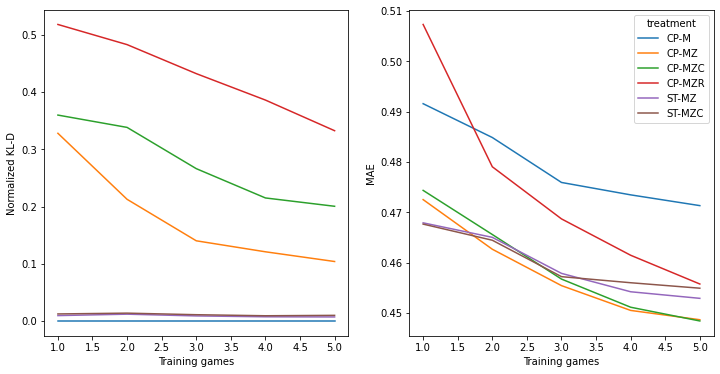

In [8]:
d = chart_data.dropna(subset=['treatment']).groupby(['treatment','games_train'], as_index=False).mean()
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.lineplot(x='games_train', y='param_distances', hue='treatment', data=d[d.games_train<6],ax=axs[0], legend=False)
axs[0].set_xlabel('Training games')
axs[0].set_ylabel('Normalized KL-D')

sns.lineplot(x='games_train', y='maes', hue='treatment', data=d[d.games_train<6],ax=axs[1])
axs[1].set_xlabel('Training games')
axs[1].set_ylabel('MAE')
plt.savefig('games_train_chart.png')

In [9]:
chart_data.dropna(subset=['treatment']).groupby(['treatment','games_train'], as_index=False).mean()

,treatment,games_train,Unnamed: 0,index,maes,param_distances,team_id
0,CP-M,1,657.545455,3.000000,0.491558,0.000000,12.954545
1,CP-M,2,666.545455,12.000000,0.484840,0.000000,12.954545
2,CP-M,3,678.545455,24.000000,0.475910,0.000000,12.954545
3,CP-M,4,686.720930,35.930233,0.473445,0.000000,12.906977
4,CP-M,5,660.947368,48.000000,0.471307,0.000000,12.315789
5,CP-M,6,637.444444,58.777778,0.464162,0.000000,11.481481
6,CP-M,7,837.000000,71.000000,0.435343,0.000000,14.333333
7,CP-MZ,1,654.545455,0.000000,0.472499,0.328011,12.954545
8,CP-MZ,2,663.545455,9.000000,0.462642,0.212629,12.954545
9,CP-MZ,3,675.545455,21.000000,0.455412,0.140123,12.954545


## Sample Paths
Generate some sample paths and compare with true paths

In [10]:
RAL, zone_df = load_data('RAL')
st_mz = MarkovModel(zone_df)
st_mz.fit(
        RAL,
        ["zone_id"],
        ["zone_id_dest"],
        "outcome",
        states=zone_df.index.values,  # states,
    )

/Users/nateaugust/Repos/audl-analysis/src/models.py:156: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.125     , 0.125     , ..., 0.        , 0.        ,
         0.04166667],
        [0.        , 0.03333333, 0.05      , ..., 0.01666667, 0.        ,
         0.08333333],
        ...,
        [0.        , 0.        , 0.        , ..., 0.16666667, 0.5       ,
         0.03703704],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  3.,  3., ...,  0.,  0.,  1.],
        [ 0.,  2.,  3., ...,  1.,  0.,  5.],
        ...,
        [ 0.,  0.,  0., ...,  9., 27.,  2.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [11]:
print(zone_df.tail(20))

          x_min   x_max   y_min  y_max  x_zone  y_zone
zone_id                                               
32        5.328  15.994   20.00   30.0     3.0     2.0
33        5.328  15.994   30.00   40.0     3.0     3.0
34        5.328  15.994   40.00   50.0     3.0     4.0
35        5.328  15.994   50.00   60.0     3.0     5.0
36        5.328  15.994   60.00   70.0     3.0     6.0
37        5.328  15.994   70.00   80.0     3.0     7.0
38        5.328  15.994   80.00   90.0     3.0     8.0
39        5.328  15.994   90.00  100.0     3.0     9.0
40       15.994  26.660    0.00   10.0     4.0     0.0
41       15.994  26.660   10.00   20.0     4.0     1.0
42       15.994  26.660   20.00   30.0     4.0     2.0
43       15.994  26.660   30.00   40.0     4.0     3.0
44       15.994  26.660   40.00   50.0     4.0     4.0
45       15.994  26.660   50.00   60.0     4.0     5.0
46       15.994  26.660   60.00   70.0     4.0     6.0
47       15.994  26.660   70.00   80.0     4.0     7.0
48       1

In [12]:
st_mz.sample_possession(26)

(array([0.]),
 array([[  26,   36,   47,   38,   51, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
         9999]]))

In [128]:
fig = make_subplots(rows=10, cols=1,shared_xaxes=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=3000,
    showlegend=False)
for i in range(1,10):
    p = st_mz.sample_possession(23)[1]
    p = np.where(p==50, 99999, p)
    p = np.where(p==51, 99998, p)
    p = p[~(p == 9999)]  # fill value
    x = np.array([zone_df.loc[zone_id]["x_zone"] for zone_id in p])
    y = np.array([zone_df.loc[zone_id]["y_zone"] for zone_id in p])

    # add some noise
    x = x + np.random.random(len(x)) - 0.5
    y = y + np.random.random(len(y)) - 0.5

    fig.add_trace(go.Scatter(x=(y + 0.5) * 10, y=(x - 2) * 10, mode="lines", marker={'color': '#636EFA'}), row=i, col=1)

    fig.layout.xaxis.update(range=(0, 125))
    fig.layout.yaxis.update(range=(-25, 25))

    fig.add_annotation(
        xref="x domain",
        yref="y domain",
        x=0.95,
        y=0.95,
        text="endzone",
        showarrow=False,
        row=i,
        col=1,
    )

fig.layout.xaxis.update(range=(0, 125))
fig.layout.yaxis.update(range=(-25, 25))
fig.layout.yaxis2.update(range=(-25, 25))
fig.layout.yaxis3.update(range=(-25, 25))
fig.layout.yaxis4.update(range=(-25, 25))
fig.layout.yaxis5.update(range=(-25, 25))
fig.layout.yaxis6.update(range=(-25, 25))
fig.layout.yaxis7.update(range=(-25, 25))
fig.layout.yaxis8.update(range=(-25, 25))
fig.layout.update(
            shapes=[
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x1",
                    "yref": f"y1",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x2",
                    "yref": f"y2",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x3",
                    "yref": f"y3",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x4",
                    "yref": f"y4",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x5",
                    "yref": f"y5",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x6",
                    "yref": f"y6",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x7",
                    "yref": f"y7",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x8",
                    "yref": f"y8",
                },
                {
                    "type": "line",
                    "x0": 100,
                    "y0": -25,
                    "x1": 100,
                    "y1": 25,
                    "xref": f"x9",
                    "yref": f"y9",
                },
            ]
        )


Layout({
    'annotations': [{'showarrow': False, 'text': 'endzone', 'x': 0.95, 'xref': 'x domain', 'y': 0.95, 'yref': 'y domain'},
                    {'showarrow': False,
                     'text': 'endzone',
                     'x': 0.95,
                     'xref': 'x2 domain',
                     'y': 0.95,
                     'yref': 'y2 domain'},
                    {'showarrow': False,
                     'text': 'endzone',
                     'x': 0.95,
                     'xref': 'x3 domain',
                     'y': 0.95,
                     'yref': 'y3 domain'},
                    {'showarrow': False,
                     'text': 'endzone',
                     'x': 0.95,
                     'xref': 'x4 domain',
                     'y': 0.95,
                     'yref': 'y4 domain'},
                    {'showarrow': False,
                     'text': 'endzone',
                     'x': 0.95,
                     'xref': 'x5 domain',
                     'y

In [130]:
fig.write_image('ST-MZ_sample_paths.png')

In [13]:
np.random.random(10)-0.5

array([-0.31235873,  0.3177326 ,  0.47596726, -0.01424669,  0.49907766,
       -0.4864628 , -0.28519763,  0.13155319, -0.20193705,  0.17661456])

In [28]:
data = pd.read_csv('data/results.csv')

In [29]:
treatment_map = {'naive': 'CP-M','ZON':'CP-MZ', 'ZRT':'CP-MZR','ZCL':'CP-MZC','MMZ':'ST-MZ', 'MMZC':'ST-MZC'}
data.loc[:,'treatment'] = data.treatment.map(treatment_map)
data.loc[:,'games_train'] = (data.games_train // 2)+1


In [57]:
my_dict = {}

for treatment, df in data[data.games_train == 5].groupby('treatment'):
    maes = []
    divs = []
    for idx, row in df.iterrows():
        maes += ast.literal_eval(row.maes.replace('nan','0'))
        divs += ast.literal_eval(row.param_distances)
    my_dict[treatment] = (maes, divs)

In [58]:
my_dict

{'CP-M': ([0.4549997165199112,
   0.45499971651991117,
   0.4559320547501636,
   0.45593205475016363,
   0.5068545037792332,
   0.5068545037792334,
   0.4972107066689032,
   0.4972107066689032,
   0.41645277978741174,
   0.4164527797874116,
   0.42208515979169003,
   0.42208515979169015,
   0.48557401194664923,
   0.48557401194664923,
   0.4825172730225504,
   0.4825172730225502,
   0.4301286633309507,
   0.43012866333095073,
   0.4339424805272618,
   0.4339424805272618,
   0.5009302663519937,
   0.5009302663519936,
   0.499221111194647,
   0.49922111119464696,
   0.48305120852807965,
   0.4830512085280796,
   0.4865472093941051,
   0.48654720939410523,
   0.5049176720990182,
   0.5049176720990183,
   0.5028193763277296,
   0.5028193763277296,
   0.49987606807547125,
   0.49987606807547125,
   0.5029535545023697,
   0.5029535545023696,
   0.4314046120843974,
   0.43140461208439745,
   0.4494386909369552,
   0.44943869093695515,
   0.4609621346682529,
   0.4609621346682529,
   0.4671680

In [54]:
ast.literal_eval(s)

[1, 2, 3]

In [72]:
ttest_ind(np.array(my_dict['CP-M'][0]), np.array(my_dict['CP-MZ'][0]), equal_var=False).pvalue

1.654235916357006e-06

In [68]:
np.mean(my_dict['CP-M'][0])

0.4713074926125625

In [77]:
import itertools
# Print out treatments that are not significantly different
for combo in list(itertools.product(my_dict.keys(), my_dict.keys())):
    if combo[0] == combo[1]:
        pass     
    else:
        # MAES
        if ttest_ind(my_dict[combo[0]][0], my_dict[combo[1]][0], equal_var=False).pvalue > 0.05:
            print(f'{combo} MAE')
        # DIVs
        if ttest_ind(my_dict[combo[0]][1], my_dict[combo[1]][1], equal_var=False).pvalue > 0.05:
            print(f'{combo} div')



('CP-MZ', 'CP-MZC') MAE
('CP-MZ', 'CP-MZR') MAE
('CP-MZ', 'ST-MZ') MAE
('CP-MZ', 'ST-MZC') MAE
('CP-MZC', 'CP-MZ') MAE
('CP-MZC', 'CP-MZR') MAE
('CP-MZC', 'ST-MZ') MAE
('CP-MZC', 'ST-MZC') MAE
('CP-MZR', 'CP-MZ') MAE
('CP-MZR', 'CP-MZC') MAE
('CP-MZR', 'ST-MZ') MAE
('CP-MZR', 'ST-MZC') MAE
('ST-MZ', 'CP-MZ') MAE
('ST-MZ', 'CP-MZC') MAE
('ST-MZ', 'CP-MZR') MAE
('ST-MZ', 'ST-MZC') MAE
('ST-MZC', 'CP-MZ') MAE
('ST-MZC', 'CP-MZC') MAE
('ST-MZC', 'CP-MZR') MAE
('ST-MZC', 'ST-MZ') MAE


In [81]:
l = []
for k, vs in my_dict.items():
    l.append({'model': k, 'mae_mean': np.mean(vs[0]), 'mae_std': np.std(vs[0]), 'div_mean': np.mean(vs[1]), 'div_std': np.std(vs[1])})

In [85]:
pd.DataFrame(l).to_csv('result_summary.csv')